# VISUALISE RESULTS

### Import relevant packages

In [135]:
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import numpy as np

from sklearn.metrics import precision_recall_fscore_support, f1_score

sns.set(font_scale=1.3)
sns.set_style()

### Load results across test sets
Each "result" is a csv of gold labels and model predictions.

In [219]:
results_dict = dict()

MODELS = ["xlmt","robertuito", "camembert", "arabert", "umberto", "bertimbau"]
SIZES = [10,20,30,40,50,100,200,300,400,500,1000,2000]
RANDOM_STATES = ["rs"+str(i) for i in range(1,11)]+["al"]

for testset in os.listdir("./results"):
    print(testset)
    results_dict[testset] = dict()
    for model in pd.unique([m.split("_")[0] for m in os.listdir(f"./results/{testset}")]):
        results_dict[testset][model] = dict()
        for size in SIZES:
            results_dict[testset][model][size] = dict()
            for random_state in RANDOM_STATES:
                for filename in glob.glob(f"./results/{testset}/{model}_*_{size}_{random_state}.csv"):
                    results_dict[testset][model][size][random_state] = pd.read_csv(filename)

bas19_es_test_2000
ous19_fr_test_1500
ous19_ar_test_1000
san20_it_test_2000
for19_pt_test_2000


### Compute macro F1 for each model/testset combination

In [220]:
metrics_dict = copy.deepcopy(results_dict)

for testset in metrics_dict:
    print(testset)
    for model in metrics_dict[testset]:
        print(" ", model)
        for size in metrics_dict[testset][model]:
            for random_state in metrics_dict[testset][model][size]:
                metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                            metrics_dict[testset][model][size][random_state]["prediction"],
                                                                            average="macro")

# remove all Englsh-only models but chosen base model
# base_model ="xlmt_dynabench2021_english_20k"        
# for dataset in metrics_dict:
#    for model,_ in list(metrics_dict[dataset].items()):
#        if dataset.split("_")[0] not in model and base_model not in model:
#            del metrics_dict[dataset][model]
    

bas19_es_test_2000
  xlmt
  robertuito
ous19_fr_test_1500
  xlmt
  camembert
ous19_ar_test_1000
  arabert
  xlmt
san20_it_test_2000
  xlmt
  umberto
for19_pt_test_2000
  bertimbau
  xlmt


### Create flat df of results for easier plotting

In [252]:
results_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                results_df.loc[len(results_df)+1] = [testset, model, size, selection_strat, metrics_dict[testset][model][size][selection_strat]]

In [253]:
results_df

,testset,model,train_size,selection_strat,macro_f1
1,bas19_es_test_2000,xlmt,10,rs1,0.544872
2,bas19_es_test_2000,xlmt,10,rs2,0.650984
3,bas19_es_test_2000,xlmt,10,rs3,0.616737
4,bas19_es_test_2000,xlmt,10,rs4,0.653481
5,bas19_es_test_2000,xlmt,10,rs5,0.648010
...,...,...,...,...,...
1256,for19_pt_test_2000,xlmt,2000,rs7,0.719085
1257,for19_pt_test_2000,xlmt,2000,rs8,0.714383
1258,for19_pt_test_2000,xlmt,2000,rs9,0.716634
1259,for19_pt_test_2000,xlmt,2000,rs10,0.726110


### Average macro F1 across random seeds for same model/testset

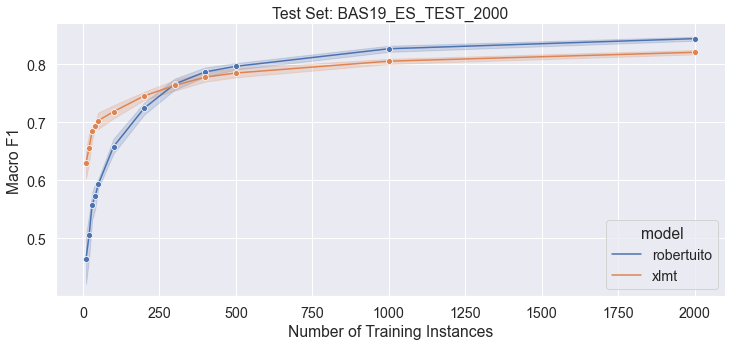

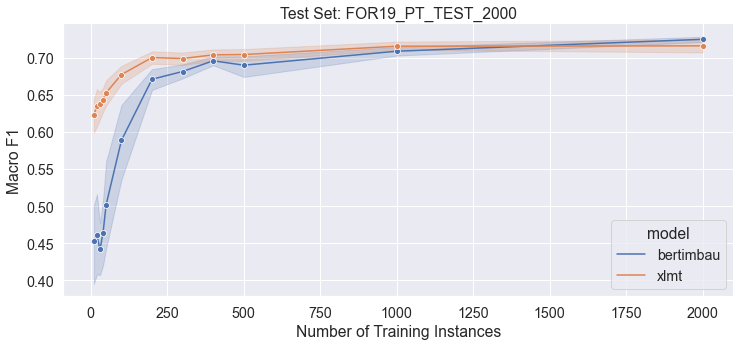

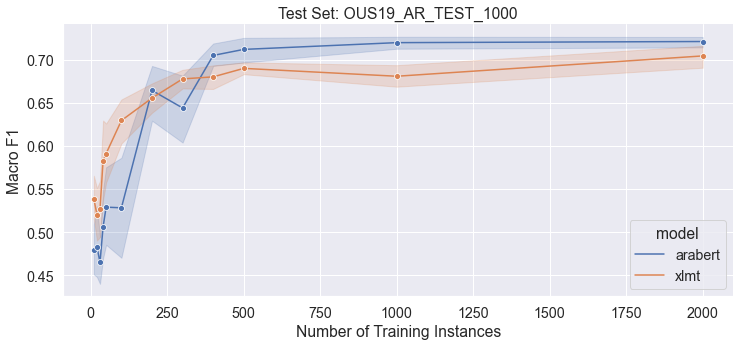

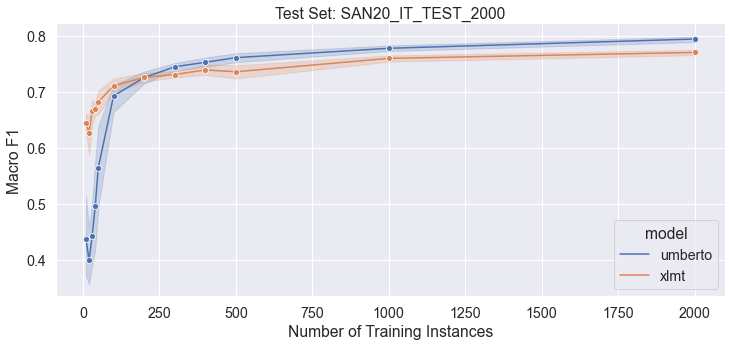

In [266]:
for target_testset in sorted([t for t in metrics_dict.keys() if "fr" not in t]):

    plot_df = results_df[(results_df.testset==target_testset) & (results_df.selection_strat!="al")].sort_values("model")
    
    f = plt.figure(figsize=(12,5))
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df,
                     estimator="mean", marker="o", ci=95)
    p.set_title(f"Test Set: {target_testset.upper()}")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    sns.despine()
    plt.show()

### Average macro F1 across random seeds for same model/testset

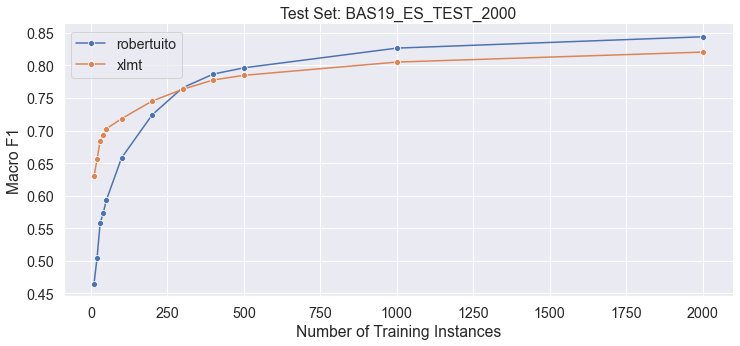

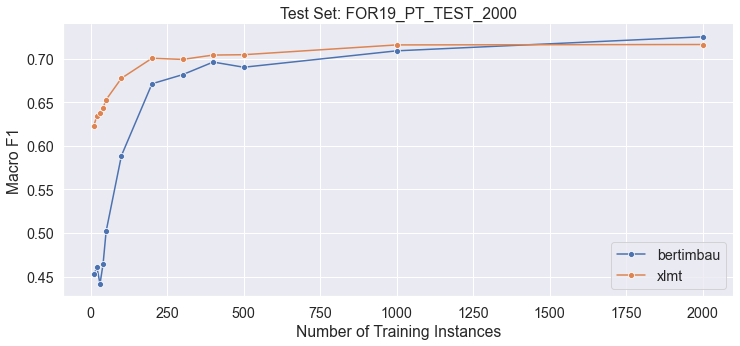

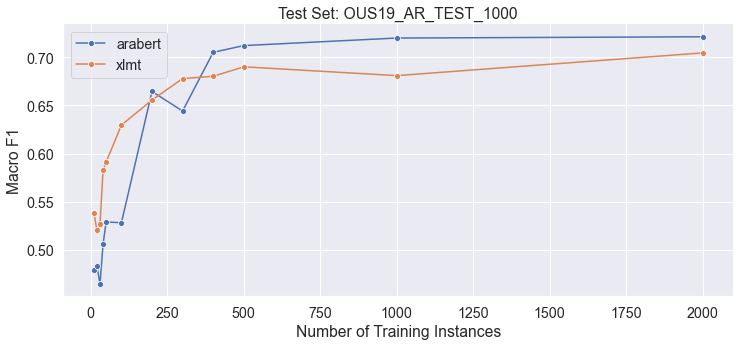

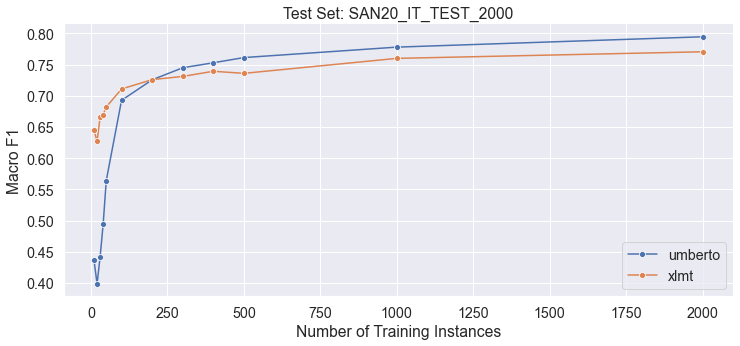

In [235]:
for target_testset in sorted([t for t in metrics_dict.keys() if "fr" not in t]):
    
    f = plt.figure(figsize=(12,5))
    
    for model in sorted(list(metrics_dict[target_testset].keys())):
        
        plot_dict = dict()
        
        for size in metrics_dict[target_testset][model]:
            
            f1_values = list(metrics_dict[target_testset][model][size][rs] for rs in metrics_dict[target_testset][model][size] if rs!="al")
            plot_dict[size] = sum(f1_values)/len(f1_values)
            
        p = sns.lineplot(x=plot_dict.keys(), y=plot_dict.values(), marker="o")
        
        #if model=="xlmt":
        #    plot_dict = dict()
        #    for size in metrics_dict[target_testset][model]:
        #        plot_dict[size] = metrics_dict[target_testset][model][size]["al"]
        #    p = sns.lineplot(x=plot_dict.keys(), y=plot_dict.values(), marker="o")
    
    plt.legend(labels=sorted(list(metrics_dict[target_testset].keys()))) #+["xlmt-al"]
    p.set_title(f"Test Set: {target_testset.upper()}")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    sns.despine()
    plt.show()